# Predicting CS Job Salaries

Austin Hensley  
April 28, 2025

### Imports

In [38]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import root_mean_squared_error

### Data Reading and Cleaning

I read in the data from salaries.csv into a pandas dataframe. I ultimately chose to drop all records where the salary was greater than $300,000. Larger salaries were often outliers which caused the models to be extremely faulty when for salaries less than $300,000.

In [39]:
df = pd.read_csv('data/salaries.csv')

sal_cap = 300000
df = df[df['salary_in_usd'] <= sal_cap]

df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
88578,2021,SE,FT,Data Specialist,165000,USD,165000,US,100,US,L
88580,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
88581,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
88582,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


The salary column needs the salary_currency column to be interpreted, as this dataset features jobs from countries all over the world. The creators of the dataset also included a salary_in_usd column, which took the salary in local currency and converted it to USD at the conversion rate in the given work year (every work year falls in the range 2020-2025). I chose to predict on the salary_in_usd column and dropped the salary column to avoid giving models information that would be unknown in a real-world (otherwise we would not need a model, just use the conversion rate of the local currecny to the dollar).

Because this data featured a lot of categorical columns, I chose to one hot encode work_year, experience_level, employment_type, salary_currency, employee_residence, remote_ratio, company_location, and company_size. Though work_year and remote_ratio are both numeric columns, we want to treat them as categrorical when training our models. This brought the total number of columns in the dataframe to 234.

In [40]:
df = df.drop(columns=['salary'])
df = pd.get_dummies(df, columns=['work_year', 'experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location', 'company_size'])

print(f'df has {len(df.columns)} columns')
df

df has 234 columns


,job_title,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,work_year_2025,experience_level_EN,experience_level_EX,...,company_location_UA,company_location_US,company_location_VE,company_location_VN,company_location_XK,company_location_ZA,company_location_ZM,company_size_L,company_size_M,company_size_S
0,Customer Success Manager,60000,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,Engineer,165000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
2,Engineer,109000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
3,Applied Scientist,294000,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
4,Applied Scientist,137600,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88578,Data Specialist,165000,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
88580,Principal Data Scientist,151000,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
88581,Data Scientist,105000,True,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
88582,Business Data Analyst,100000,True,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False


I wanted to create some synthetic features to see if they improve the model quality. This dataset features a text field called job_title which has no missing values. I generated a list of all keywords, adding both single keywords and bigrams that appeared within the job titles. There were 457 total keywords within the given dataset.

In [41]:
# find single and bigram keywords

job_title_keywords = set()

for job_title in df['job_title']:
    keyword_list = job_title.strip().lower().replace('&', 'and').split(' ')

    for i in range(len(keyword_list) - 1):
        job_title_keywords.add(keyword_list[i])
        job_title_keywords.add(f'{keyword_list[i]} {keyword_list[i+1]}')

    job_title_keywords.add(keyword_list[-1])
    
a = list(job_title_keywords)
a.sort()

print(a)
print(len(job_title_keywords))

['account', 'account executive', 'actuarial', 'actuarial analyst', 'admin', 'admin and', 'administrator', 'advocate', 'ai', 'ai architect', 'ai data', 'ai developer', 'ai engineer', 'ai engineering', 'ai governance', 'ai lead', 'ai machine', 'ai ml', 'ai product', 'ai programmer', 'ai research', 'ai researcher', 'ai scientist', 'ai software', 'ai solution', 'ai specialist', 'algorithm', 'algorithm developer', 'analysis', 'analyst', 'analyst lead', 'analytics', 'analytics analyst', 'analytics associate', 'analytics consultant', 'analytics developer', 'analytics engineer', 'analytics lead', 'analytics manager', 'analytics specialist', 'analytics team', 'and', 'and data', 'and reporting', 'application', 'application delivery', 'application developer', 'applied', 'applied ai', 'applied data', 'applied machine', 'applied research', 'applied scientist', 'architect', 'artificial', 'artificial intelligence', 'assistant', 'associate', 'autonomous', 'autonomous vehicle', 'aws', 'aws data', 'azur

I added binary columns for every job title keyword or bigram that appeared in at least 100 of the records. I chose 100 as my threshold to avoid overfitting when training models. I was suprised that this is the longest step in the cleaning process, but it makes sense because I have to run the contains function 85,351 x 457 times = 39 million times. I also have to take the sum of each column to see if it has at least 100 true values, which can become an expensive operation when done repeatedly. This process brought the total number of columns in the synthetic dataset up to 359.

In [ ]:
df_synthetic = df.copy()

df_synthetic['job_title_lower'] = df_synthetic['job_title'].str.lower().replace('&', 'and')

new_cols = {}

for keyword in job_title_keywords:
    col_name = f'keyword_{keyword}'
    new_col = df_synthetic['job_title_lower'].str.contains(rf'\b{keyword}\b', regex=True)
    if sum(new_col) >= 100:
        new_cols[col_name] = new_col

df_synthetic = pd.concat([df_synthetic, pd.DataFrame(new_cols)], axis=1)

df_synthetic = df_synthetic.drop(columns=['job_title_lower', 'job_title'])
df = df.drop(columns=['job_title'])

print(f'df_synthetic has {len(df_synthetic.columns)} columns')
df_synthetic

df_synthetic has 359 columns


,salary_in_usd,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,work_year_2025,experience_level_EN,experience_level_EX,experience_level_MI,...,keyword_cloud engineer,keyword_systems engineer,keyword_mlops,keyword_engineering,keyword_ai,keyword_ai engineer,keyword_engineer,keyword_head,keyword_integration,keyword_technical lead
0,60000,False,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,165000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,109000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,294000,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,137600,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88578,165000,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
88580,151000,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
88581,105000,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
88582,100000,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


### Models

Salaries are numeric discrete values, so I needed to train regression models in order to predict it. In my data cleaning I converted all of the categorical columns into binary features in order to use linear regression. The first model I trained was on the cleaned dataframe without the synthetic job title keyword columns. I treated this as my baseline model due to its trivial cleaning steps and the simplicity of the model type. I also chose to use RMSE as my way to measure accuracy because it uses the dollar as its unit. I split the data into 80% training and 20% testing.

This initial model had an RMSE = $53,000. This was a little higher than I expected, but salaries can vary wildly depending on a large number of factors that are not included in this dataset. 85,000 records is also a little small considering the vast array of job titles and the sheer number of countries included within the data. The red line on the plot represents the line y=x, so in an ideal model all points would fall directly on that line.

Root Mean Squared Error: 53051.92
Coefficients: [2161.2320332012105, -2570.3331602307117, -6374.424702335164, -612.4562643759054, 5615.571385703394, 1780.4107080385802, -42904.35215566115, 36034.396218858135, -10132.073830497644, 17002.02976730452, -259.9147006476951, -4487.303824670191, 21340.251079507943, -16593.032554188077, -9494.984284959028, -5346.669165637279, 2557.078486094033, -9909.629267943375, 6557.41540907426, -56330.21608128009, 34122.94420571824, -13717.308000673223, -38721.61404677663, -3617.3556516726344, 3827.2660905452763, 54623.3594044253, -9317.117743203216, -5728.026620118597, 25067.304919767277, 13706.830660747282, 68022.25590197644, 16556.930076944744, -2738.131412323877, 3.54702933691442e-11, -41650.100970399675, 2905.355159033282, -20249.084349383116, -5225.423829458602, 32020.47801596545, -37921.55690645649, 5457.16187275447, -9683.807498749717, -101666.75299053088, -34848.43595629866, -6004.345034473012, -217.84608222598763, 35164.09465521241, -1079.07107096

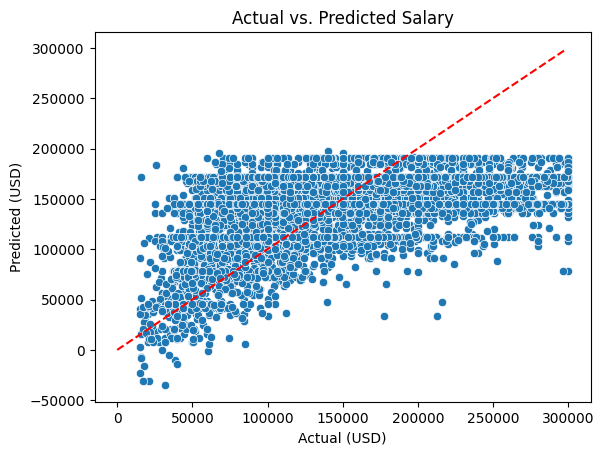

In [43]:
prediction_col = 'salary_in_usd'

X = df.drop(columns=[prediction_col])
y = df[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

For the second model, I chose to use the dataset with the synthetic keyword columns I created. This model outperformed the baseline model; it had an RMSE = $48,900. One interesting observation from the plots is that the second model seems to performs better on salaries > $150k than the first model, but the first model tends to performs better on salaries < $150k than the second model.

Root Mean Squared Error: 48925.93
Coefficients: [2024.483553754122, -3573.1893072113708, -2932.7246706692113, 1199.8939491510428, 2402.856856606641, 878.679618372535, -29037.174187910452, 32297.39281840863, -13688.895949538623, 10428.6773190462, -48.69775590770041, 320.70607372991435, 15551.368745211148, -15823.37706303128, -8623.34022731127, -9781.366092058139, 2489.797101874799, 11096.42045982027, 4507.267983789829, -63818.23905986283, 34417.41330609434, -15199.983056263696, -26120.090968842556, -3457.989655347277, 15673.9265634091, 20745.376250372952, -5072.09526262796, -23662.30009420433, -2027.9727203349212, 21753.023004034556, 85773.5157640287, 13500.769703163296, -2984.6833948232816, 7.275957614183426e-11, -11399.083857113073, 18093.656375372553, -25916.38686355057, -10616.93780109216, 33248.981142441604, -52619.67860097624, 13494.25217649395, -17334.178016905404, -66838.74152837903, -13631.5428577611, 826.7542104925622, 2367.2975929402737, 48888.60527895936, -2149.654432035902,

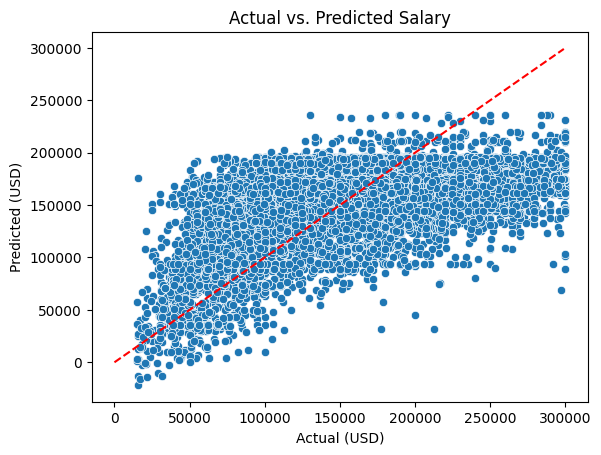

In [44]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficients: {model.coef_.tolist()}")
print(f"Intercept: {model.intercept_}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

For the third model, I chose to use sklearns SelectKBest method to keep the 20 columns which represent the most variance within the salaries. I ran feature selection on the dataset with the synthetic features. Half of the selected columns ended up being one of the synthetic columns I created.

In [53]:
selector = SelectKBest(score_func=f_regression, k=20)
X_new = selector.fit_transform(X, y)

# Get selected column names
selected_columns = X.columns[selector.get_support()]

for col in selected_columns:
    print(col)

experience_level_EN
experience_level_MI
experience_level_SE
salary_currency_EUR
salary_currency_GBP
salary_currency_USD
employee_residence_GB
employee_residence_US
company_location_GB
company_location_US
keyword_learning
keyword_machine
keyword_learning engineer
keyword_software
keyword_data analyst
keyword_machine learning
keyword_software engineer
keyword_analyst
keyword_data
keyword_engineer


I trained another linear regression model just using the 20 selected features. This model was better than the baseline, but slightly worse than the model with all the features (original + snythetic). The feature selection model has a RMSE = $50,900. Feature selection would be good to use if there was millions of records, as it would speed up training time and simplify the number of parameters needed, but because we only have 85,000 records it is unnecessary.

Root Mean Squared Error: 50935.40

Coefficients:
	experience_level_EN      -63420.36
	experience_level_MI      -48583.66
	experience_level_SE      -22392.01
	salary_currency_EUR      -10956.47
	salary_currency_GBP      -21309.11
	salary_currency_USD      42447.63
	employee_residence_GB    21741.76
	employee_residence_US    41359.80
	company_location_GB      7453.54
	company_location_US      -14728.40
	keyword_learning         -12137.06
	keyword_machine          -81828.82
	keyword_learning engineer 32810.59
	keyword_software         -6869.21
	keyword_data analyst     7752.41
	keyword_machine learning 82336.59
	keyword_software engineer 23751.74
	keyword_analyst          -36983.42
	keyword_data             -12817.76
	keyword_engineer         -1380.12
Intercept: 127713.57


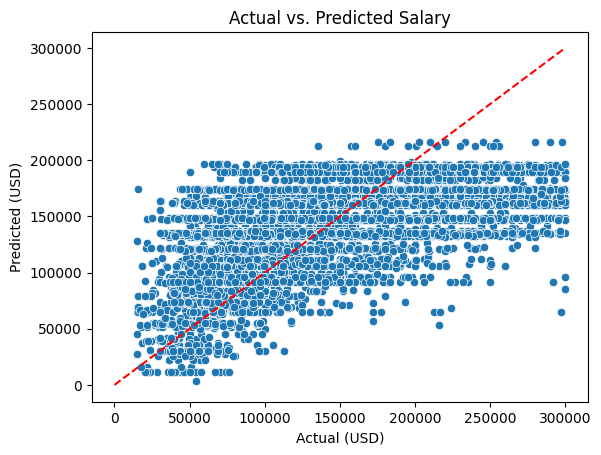

In [46]:
prediction_col = 'salary_in_usd'

X = df_synthetic[selected_columns]
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"\nCoefficients:")
for i in range(len(selected_columns)):
    print(f"\t{selected_columns[i].ljust(24)} {model.coef_.tolist()[i]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

For my fourth model I wanted to try non-linear regression models. I chose to go with a decision tree regressor. I trained it using the data with synthetic features and required that there must be at least 10 samples in each leaf node to prevent overfitting. This model had an RMSE = $48,800, which was ever-so-slightly better than the linear regression model on the dataset with synthetic features. Trees had outperformed linear models for this dataset, which makes sense considering the number of categorical features in the dataset.

Root Mean Squared Error: 48778.52


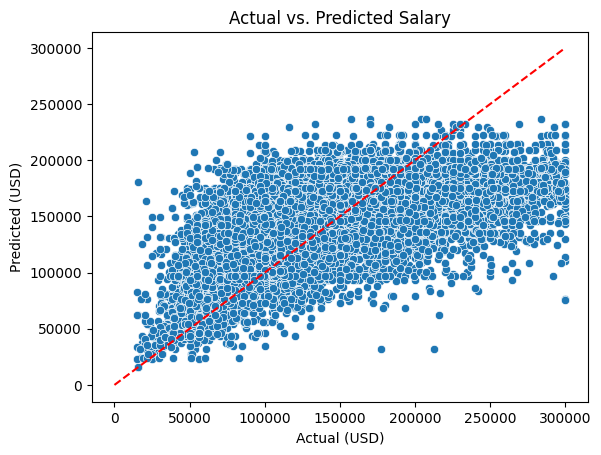

In [47]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = DecisionTreeRegressor(min_samples_leaf=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

For my final model I chose to run a random forest regressor. I kept the same model parameters as the decision tree regressor, as I was hoping that this model would be a further optimization of it. The random forest model was slightly better, having an RMSE = $48,600. Out of the five models I trained, random forest regressor was the best.

Root Mean Squared Error: 48617.64


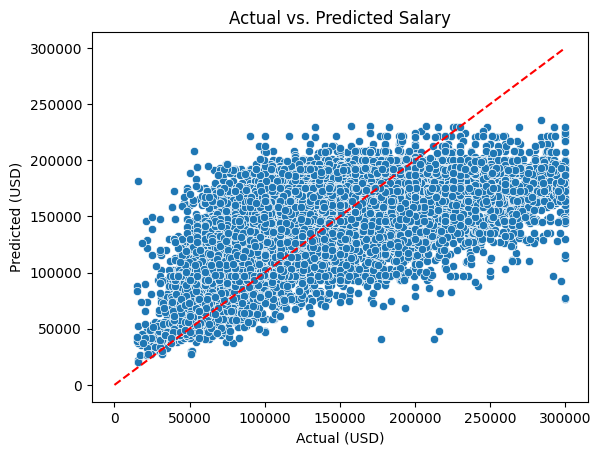

In [48]:
prediction_col = 'salary_in_usd'

X = df_synthetic.drop(columns=[prediction_col])
y = df_synthetic[prediction_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

model = RandomForestRegressor(min_samples_leaf=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")

plot = sns.scatterplot(x=y_test, y=y_pred)
vals = range(0,sal_cap,1000)
plt.plot(vals, vals, color='red', linestyle='--', label='y=x')
plt.title('Actual vs. Predicted Salary')
plt.xlabel('Actual (USD)')
plt.ylabel('Predicted (USD)')
plt.show()

### Summary of Model Results

| <center>Model</center> | <center>RMSE (in $)</center> |
| --- | --- |
| Linear (original data) | 53,000 |
| Linear (synthetic data) | 48,900 |
| Linear (feature selection) | 50,900 |
| Decision Tree Regressor | 48,800 |
| Random Forest Regressor | 48,600 |